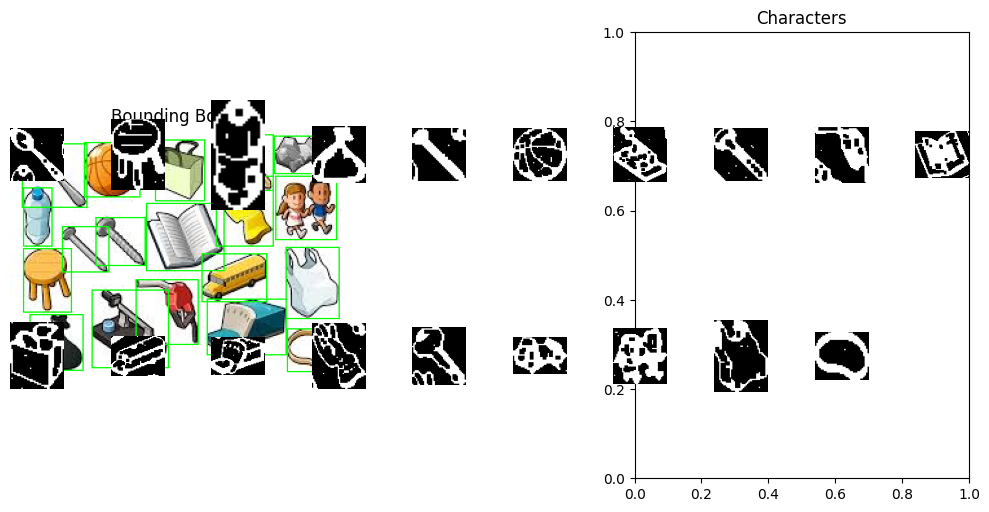

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found or path is incorrect.")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Adaptive thresholding
    binary = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 10
    )

    # Optional: connect broken parts
    kernel = np.ones((3, 3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    return img, gray, binary


def extract_characters(binary_image, min_area=100):
    contours, _ = cv2.findContours(
        binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    bounding_boxes = []
    characters = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        if area > min_area:
            roi = binary_image[y : y + h, x : x + w]
            characters.append(roi)
            bounding_boxes.append((x, y, w, h))

    # Sort left to right
    characters = [
        char
        for _, char in sorted(zip(bounding_boxes, characters), key=lambda b: b[0][0])
    ]
    bounding_boxes = sorted(bounding_boxes, key=lambda b: b[0])

    return characters, bounding_boxes


def visualize(image, boxes, characters):
    # Draw boxes
    for x, y, w, h in boxes:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Bounding Boxes")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Characters")
    for i, char in enumerate(characters):
        plt.subplot(2, len(characters) // 2 + 1, i + 1)
        plt.imshow(char, cmap="gray")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


def segment_characters(image_path, min_area=100):
    image, gray, binary = preprocess_image(image_path)
    characters, boxes = extract_characters(binary, min_area)
    visualize(image.copy(), boxes, characters)


# 🔧 Run the function on your image
if __name__ == "__main__":
    segment_characters("stdimgs/objects.jpeg", min_area=150)